In [1]:
# Setup
# set this to your working directory
WORKING_DIR = '/home/elliott/Dropbox/_Ash_Teaching/2018-09 - Bocconi - Text Data and ML/code'
import os
os.chdir(WORKING_DIR)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')
X = pd.read_pickle('X.pkl').toarray()
vocab = pd.read_pickle('vocab.pkl')
Y = df1['citeCount']
df1['has_cites'] = (df1['citeCount'] > 0).astype(int)

In [2]:
#%% Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([ 0.07618071,  0.05286707,  0.04029217])

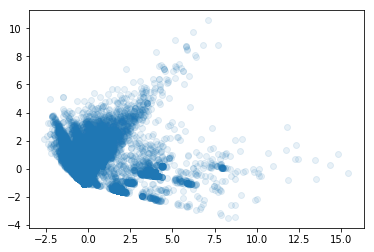

In [3]:
#%% PCA Viz
plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)
plt.show()

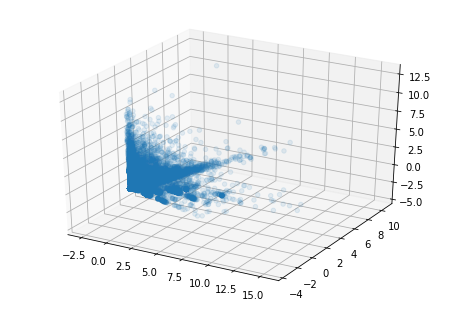

In [4]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [5]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

253

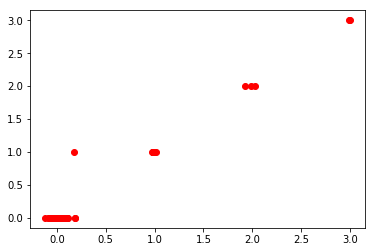

In [6]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plt.plot(Xrestore[0],X[0],'ro')

In [7]:
#%% Incremental PCA
X_mm = np.memmap('X.pkl',shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X_mm)


IncrementalPCA(batch_size=1000, copy=True, n_components=100, whiten=False)

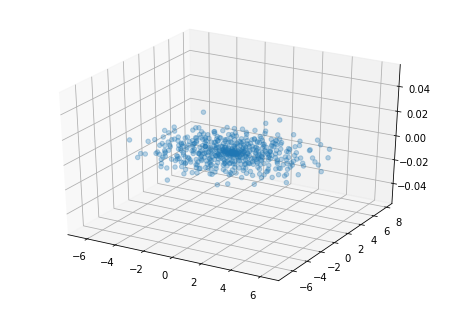

In [8]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xmds[:,0],Xmds[:,1], alpha=.3)

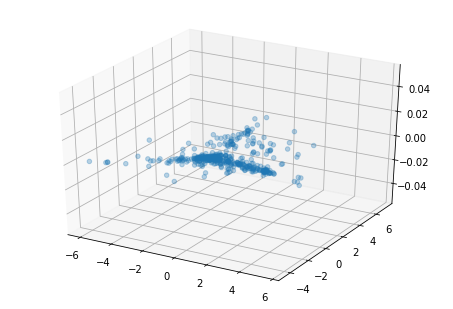

In [9]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xiso[:,0],Xiso[:,1], alpha=.3)

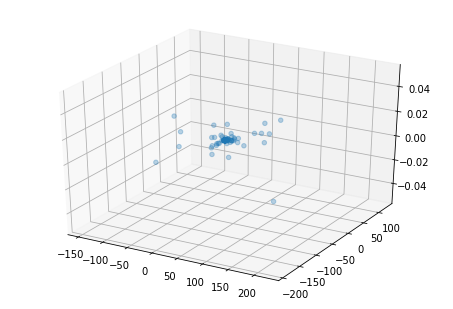

In [10]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=250)
Xtsne = tsne.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xtsne[:,0],Xtsne[:,1], alpha=.3)

In [11]:
#%% PC Regression
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

-5.8261616540400958

In [12]:
#%% Partial Least Squares
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=10)
Xpls, Ypls = pls.fit_transform(X,Y)

/home/elliott/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/elliott/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


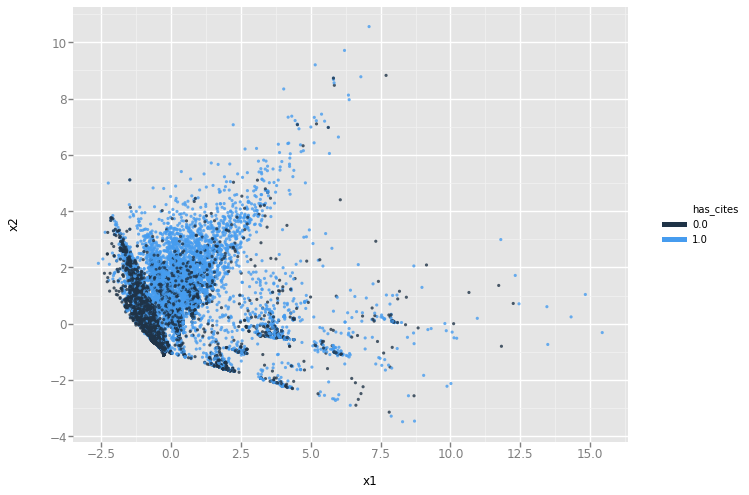

In [13]:
#%% Visualization with labeling
import ggplot as gg
df1['x1'], df1['x2'] = Xpca[:,0],Xpca[:,1]
chart = gg.ggplot( df1, gg.aes(x='x1', y='x2', color='has_cites') ) \
                  + gg.geom_point(size=10, alpha=.8) 
chart.show()

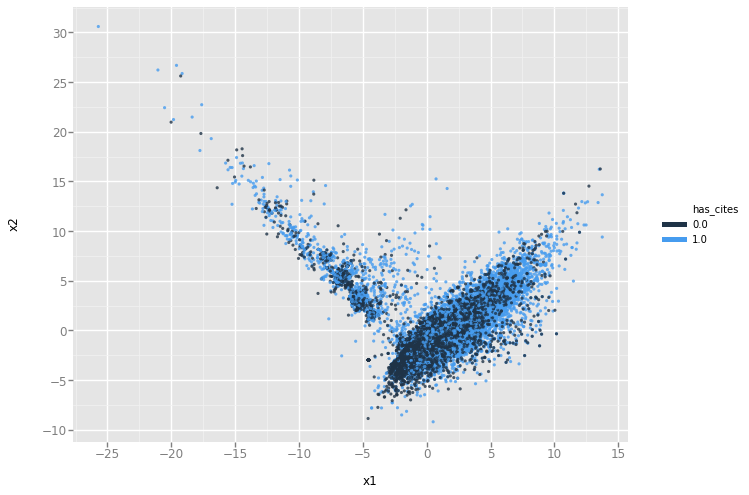

In [14]:
#%% PLS transformation
df1['x1'], df1['x2'] = Xpls[:,0],Xpls[:,1]
chart = gg.ggplot( df1, gg.aes(x='x1', y='x2', color='has_cites') ) \
                  + gg.geom_point(size=10, alpha=.8) 
chart.show()

In [15]:
#%% Feature Selection with Elastic Net
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
from sklearn.linear_model import ElasticNet
enet_reg = ElasticNet(alpha=.1, l1_ratio=.5)
enet_reg.fit(Xscale,Y)
nonzero = enet_reg.coef_ != 0
print(nonzero.sum(),'non-zero of',len(enet_reg.coef_),'coefficients.')
X_enet = X[:,nonzero]
cross_val_score(pls,X_enet,Y,n_jobs=-1).mean()

/home/elliott/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/elliott/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


402 non-zero of 472 coefficients.


-6.8415697857403117

In [ ]:
#%% Univariate feature selection using chi2
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, f_classif, mutual_info_classif
select = SelectKBest(chi2, k=10)
X_new = select.fit_transform(X, Y)
# top 10 features by chi-squared:
[vocab[i] for i in np.argsort(select.scores_)[:10]]

In [ ]:
#%% top 10 features by  ANOVA F-value:
select = SelectKBest(f_classif, k=10)
select.fit(X, Y)
[vocab[i] for i in np.argsort(select.scores_)[:10]]

In [ ]:
#%% top 10 features by linear regression
select = SelectKBest(f_regression, k=10)
select.fit(X, Y)
[vocab[i] for i in np.argsort(select.scores_)[:10]]

In [ ]:
#%% top 10 features by mutual information (classification)
select = SelectKBest(mutual_info_classif, k=10)
select.fit(X[:1000], Y[:1000])
[vocab[i] for i in np.argsort(select.scores_)[:10]]